In [1]:
import pandas as pd
import numpy as np

import csv

from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter
from lifelines import CoxPHFitter
from lifelines import WeibullFitter

from lifelines.utils import median_survival_times
from lifelines.utils import find_best_parametric_model

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from empiricaldist import Pmf  

from scipy.stats import probplot

from datetime import datetime, timezone
from matplotlib_venn import venn3
from supervenn import supervenn

from datetime import datetime, timedelta

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore')

In [3]:
# Set a random seed for reproducibility
np.random.seed(42)

In [4]:
csv.field_size_limit(100000000)

131072

***
## Data Preprocessing
***

Let's use the dataframe created before by joining CVE list, CISA KEV, CVSS Scores and EPSS Scores information, to make the synthetically generated data more realistic.

In [5]:
original_data = pd.read_csv('cve_epss_cvss.csv', encoding = 'utf-8-sig', engine = 'python')
original_data['publishedDate'] = pd.to_datetime(original_data['publishedDate'], errors='coerce')

In [6]:
# Get the current date and time in UTC
current_utc_time = pd.Timestamp.now(tz='UTC')

# Calculate the time difference
original_data['days_difference'] = (current_utc_time - original_data['publishedDate']).dt.total_seconds() / (60 * 60 * 24)

# Convert to integer if you want the result as a whole number of days
original_data['days_difference'] = original_data['days_difference'].astype(int)

In [7]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229453 entries, 0 to 229452
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   publishedDate               229453 non-null  datetime64[ns, UTC]
 1   lastModifiedDate            229453 non-null  object             
 2   cveID                       229453 non-null  object             
 3   assigner                    229453 non-null  object             
 4   configurations.nodes        229453 non-null  object             
 5   version                     141850 non-null  float64            
 6   vectorString                141850 non-null  object             
 7   attackVector                141850 non-null  object             
 8   attackComplexity            141850 non-null  object             
 9   privilegesRequired          141850 non-null  object             
 10  userInteraction             141850 non-null 

In [8]:
# Map numerical values to criticality levels and add a 'Criticality' column to the DataFrame.

def map_criticality(df):
    # Define the mapping function
    def map_to_criticality(value):
        if 0 <= value < 4:
            return 'Low'
        elif 4 <= value < 7:
            return 'Medium'
        elif 7 <= value < 9:
            return 'High'
        elif 9 <= value <= 10:
            return 'Critical'
        else:
            return 'Low'

    # Apply the mapping function to create the 'Criticality' column
    df['Criticality'] = df['cvssScore'].apply(map_to_criticality)

    return df

In [9]:
original_data = map_criticality(original_data)

In [10]:
# Convert 'publishedDate' to datetime if not already done
original_data['publishedDate'] = pd.to_datetime(original_data['publishedDate'])

In [11]:
# Ratio of criticality scores in the synthetic dataset (e.g., [0.4, 0.3, 0.2, 0.1]).
CRITICALITY_RATIO = [0.15, 0.7, 0.1, 0.05]
# Number of samples to generate in the synthetic dataset.
NUM_SAMPLES = 10000

***
## Data Generation
***

In [12]:
# Generate a synthetic dataset with time-to-remediate based on the criticality score.
def generate_synthetic_data(original_data, num_samples, criticality_ratio):
    # Check if the 'Criticality' and 'Exploitability' columns are present in the original data
    required_columns = {'Criticality', 'epss', 'cvssScore', 'publishedDate'}
    if not required_columns.issubset(original_data.columns):
        raise KeyError(f"The columns {required_columns} are not present in the original_data DataFrame.")

    # Check if the criticality_ratio is valid
    if len(criticality_ratio) != len(original_data['Criticality'].unique()):
        raise ValueError("The length of criticality_ratio should match the number of unique criticality scores.")

    # Get the current date and time in UTC, minus one week
    current_date_minus_one_week = pd.Timestamp.now(tz='UTC') - timedelta(weeks=1)
    
    # Initialize an empty DataFrame for the synthetic data
    synthetic_data = pd.DataFrame(columns=['Time_to_Remediate', 'Criticality', 'CVSS_Score', 'Exploitability',  'Known_Exploit', 'CVE_ID', 'Remediated', 'Observed_Date'])

    # Generate synthetic data based on the given ratio
    for ratio, crit_level in zip(criticality_ratio, original_data['Criticality'].unique()):
        # Check if there are vulnerabilities for the current criticality level
        if crit_level not in original_data['Criticality'].values:
            continue

        # Calculate the number of samples for the current criticality level
        num_samples_crit_level = int(num_samples * ratio)

        # Randomly select vulnerabilities for the current criticality level
        subset_data = original_data[original_data['Criticality'] == crit_level]

        # Check if there are vulnerabilities for the current criticality level
        if subset_data.empty:
            continue

        sampled_indices = np.random.choice(subset_data.index, size=num_samples_crit_level, replace=True)

        # Extract CVSS scores for selected vulnerabilities
        cvss_score = subset_data.loc[sampled_indices, 'cvssScore'].values

        # Extract exploitability scores for selected vulnerabilities
        exploitability = subset_data.loc[sampled_indices, 'epss'].values
        
        # Extract age for selected vulnerabilities
#         days_difference = subset_data.loc[sampled_indices, 'days_difference'].values
        # Instead of using 'days_difference', generate a realistic 'Time_to_Remediate'
        # For example, using a normal distribution with a mean and standard deviation
        mean_remediate_time = 250 # mean time to remediate (days)
        std_deviation = 150  # standard deviation (days)
        remediation_times = np.random.normal(mean_remediate_time, std_deviation, num_samples_crit_level)
        remediation_times = np.clip(remediation_times, 0, None)  # Ensure all times are positive


        known_exploit = subset_data.loc[sampled_indices, 'hasKEV'].values
        cve_id = subset_data.loc[sampled_indices, 'cveID'].values

       # Generate random Observed_Dates
        published_dates = subset_data.loc[sampled_indices, 'publishedDate']
        observed_dates = published_dates.apply(
            lambda x: x + (current_date_minus_one_week - x) * np.random.rand()
        )


       # Create a DataFrame with the generated data
        synthetic_subset = pd.DataFrame({
            'Time_to_Remediate': remediation_times,
            'Criticality': [crit_level] * num_samples_crit_level,
            'CVSS_Score': cvss_score,
            'Exploitability': exploitability,
            'Remediated': np.random.choice([0, 1], size=num_samples_crit_level),  # Random choice of 0 or 1 for 'Remediated'
            'Known_Exploit': known_exploit,
            'CVE_ID': cve_id,
            'Observed_Date': observed_dates
 
        })

        # Append the synthetic subset to the overall synthetic data
        synthetic_data = synthetic_data.append(synthetic_subset)

    # Reset the index of the synthetic data
    synthetic_data.reset_index(drop=True, inplace=True)

    return synthetic_data


I initially used the vulnerability age since publish date to approximate the time to remediate. However, this was not a realistic approximation of reality. Time_to_Remediate is generated using a normal distribution centered around a mean time-to-remediate (30/90/180 days for example) with a standard deviation (10 days). 

In [13]:
# Generate synthetic data with NUM_SAMPLES vulnerabilities
synthetic_data = generate_synthetic_data(original_data, NUM_SAMPLES, CRITICALITY_RATIO)

In [14]:
synthetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   Time_to_Remediate  10000 non-null  float64            
 1   Criticality        10000 non-null  object             
 2   CVSS_Score         10000 non-null  float64            
 3   Exploitability     10000 non-null  float64            
 4   Known_Exploit      10000 non-null  float64            
 5   CVE_ID             10000 non-null  object             
 6   Remediated         10000 non-null  object             
 7   Observed_Date      10000 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(4), object(3)
memory usage: 625.1+ KB


In [15]:
# Convert relevant columns to numeric and handle NaNs
synthetic_data['Time_to_Remediate'] = pd.to_numeric(synthetic_data['Time_to_Remediate'], errors='coerce')
synthetic_data['Remediated'] = pd.to_numeric(synthetic_data['Remediated'], errors='coerce')

In [16]:
synthetic_data.describe()

,Time_to_Remediate,CVSS_Score,Exploitability,Known_Exploit,Remediated
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,251.259858,6.895570,0.022824,0.057400,0.498000
std,143.819511,2.518952,0.117598,0.232617,0.500021
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,145.232563,6.950000,0.000560,0.000000,0.000000
50%,249.217067,7.500000,0.001050,0.000000,0.000000
75%,350.205915,8.100000,0.002800,0.000000,1.000000
max,789.920017,10.000000,0.975160,1.000000,1.000000


***
## Exploratory Data Analysis
***

In [17]:
# Function to plot the distribution of criticality values
def plot_criticality_distribution(data):
    criticality_counts = data['Criticality'].value_counts()
    
    # Plot a bar chart
    criticality_counts.plot(kind='bar', color=['darkred', 'grey', 'lightblue', 'darkgrey'])
    
    # Add labels and title
    plt.title("Distribution of Vulnerabilities by Criticality")
    plt.xlabel("Criticality Level")
    plt.ylabel("Number of Vulnerabilities")
    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
    
    # Display the plot
    plt.show()

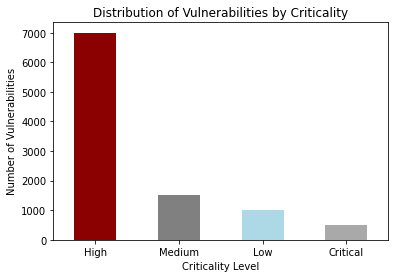

In [18]:
# Plot the distribution of criticality values
plot_criticality_distribution(synthetic_data)

In [19]:
# Function to plot the distribution of exploitability values
def plot_exploitability_distribution(data):
    # Plot a histogram of exploitability values
    plt.hist(data['Exploitability'], bins=20, color='darkred')
    
    # Add labels and title
    plt.title("Distribution of Initial Exploitability Values")
    plt.xlabel("Exploitability")
    plt.ylabel("Number of Vulnerabilities")
    
    # Display the plot
    plt.show()

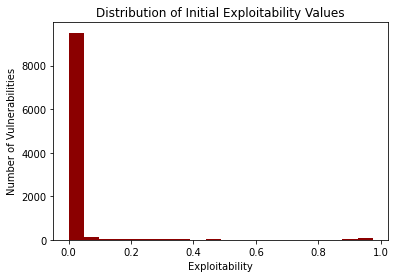

In [20]:
# Plot the distribution of exploitability values
plot_exploitability_distribution(synthetic_data)

In [21]:
# Function to plot the distribution of exploitability values
def plot_age_distribution(data):
    # Plot a histogram of exploitability values
    plt.hist(data['Time_to_Remediate'], bins=20, color='darkred')
    
    # Add labels and title
    plt.title("Distribution of Remediation times")
    plt.xlabel("Age")
    plt.ylabel("Number of Vulnerabilities")
    
    # Display the plot
    plt.show()

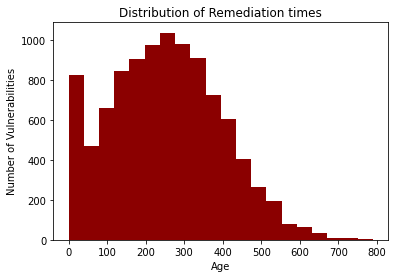

In [22]:
# Plot the distribution of exploitability values
plot_age_distribution(synthetic_data)

***
## Metrics
***

In [23]:
def venn_diagram(a, b, c, labels):

    a = set(a)
    b = set(b)
    c = set(c)

    only_a = len(a - b - c)
    only_b = len(b - a - c)
    only_c = len(c - a - b)

    only_a_b = len(a & b - c)
    only_a_c = len(a & c - b)
    only_b_c = len(b & c - a)

    a_b_c = len(a & b & c)

    venn3(subsets=(only_a, only_b, only_a_b, only_c, only_a_c, only_b_c, a_b_c), set_labels=labels,
         set_colors=("lightblue", "darkred", "grey"), alpha=0.8)

In [24]:
a = synthetic_data.loc[synthetic_data['Known_Exploit'] == 1, 'CVE_ID']
b = synthetic_data.loc[synthetic_data['CVSS_Score'] >= 7, 'CVE_ID']
c = synthetic_data.CVE_ID
labels = ['Present in KEV', 'CVSS7+', 'EPSS']

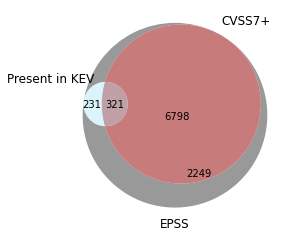

In [25]:
venn_diagram(a, b, c, labels)

In [26]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [27]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(synthetic_data) * 100))

Patching effort: 71.19%


In [28]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

Efficiency: 4.51%


In [29]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

Coverage: 100.00%


In [30]:
a = synthetic_data.loc[synthetic_data['Known_Exploit'] == 1, 'CVE_ID']
b = synthetic_data.CVE_ID
c = synthetic_data.loc[synthetic_data['Exploitability'] > 0.1, 'CVE_ID']


labels = ['Present in KEV', 'CVSS', 'EPSS 0.1+']

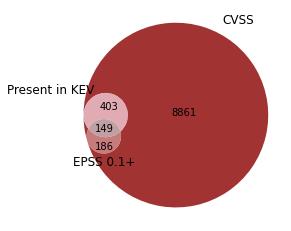

In [31]:
venn_diagram(a, b, c, labels)

In [32]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [33]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(synthetic_data) * 100))

Patching effort: 3.35%


In [34]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

Efficiency: 44.48%


In [35]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

Coverage: 26.99%


In [36]:
a = synthetic_data.loc[synthetic_data['Known_Exploit'] == 1, 'CVE_ID']
b = synthetic_data.CVE_ID
c = synthetic_data.loc[synthetic_data['Exploitability'] > 0.36, 'CVE_ID']


labels = ['Present in KEV', 'CVSS', 'EPSS 0.36+']

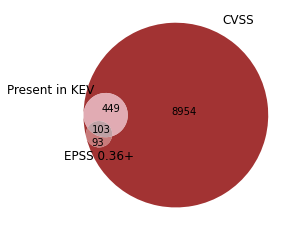

In [37]:
venn_diagram(a, b, c, labels)

In [38]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [39]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(synthetic_data) * 100))

Patching effort: 1.96%


In [40]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

Efficiency: 52.55%


In [41]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

Coverage: 18.66%


In [42]:
# Set the index to the date
data_by_date = synthetic_data.set_index('Observed_Date')

In [43]:
# Resample and count vulnerabilities per day
vulnerabilities_per_day = data_by_date.resample('D').count()

In [44]:
# Calculate the average arrival rate per day
average_arrival_rate = vulnerabilities_per_day['CVE_ID'].mean()
print("Average arrival rate: {:.2f}".format(average_arrival_rate))

Average arrival rate: 1.30


In [45]:
# Since 'Remediated' is a binary column where 1 indicates remediation
remediation_rate = synthetic_data['Remediated'].mean()

# Convert rate to a percentage
print(f"Remediation rate: {remediation_rate * 100:.2f}%")

Remediation rate: 49.80%


***
## Survival Analysis
***

***
### Overall Survival
***

In [46]:
# Function to calculate overall hazard using the Kaplan-Meier estimator
def calculate_overall_hazard(data):
    # Identify events (1) and censored observations (0)
    event_observed = np.where(data['Remediated'] == 1, 1, 0)
    kmf = KaplanMeierFitter()
    kmf.fit(durations=data['Time_to_Remediate'], event_observed=event_observed)
    
    # Calculate the negative logarithm of the survival function (proportional to hazard function)
    overall_hazard = -np.log(kmf.survival_function_)
    
    return overall_hazard

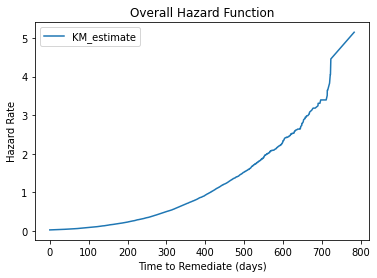

In [47]:
# Calculate and plot the overall hazard function
overall_hazard = calculate_overall_hazard(synthetic_data)
overall_hazard.plot(label="Overall")
plt.title("Overall Hazard Function")
plt.xlabel("Time to Remediate (days)")
plt.ylabel("Hazard Rate")
plt.legend()
plt.show()

***
### Weibull Fitter
***
Weibull distribution: the failure/event rate is proportional to time.

In [48]:
def perform_weibull_analysis(data):

    # Add a small positive value to zero elements in 'Time_to_Remediate'
    data['Time_to_Remediate'] = np.maximum(data['Time_to_Remediate'], 1e-6)

    wb = WeibullFitter()

    # Fit the Weibull model
    wb.fit(data['Time_to_Remediate'], data['Remediated'])

    # Print the summary
    wb.print_summary()

    # Plot survival function
    wb.survival_function_.plot()
    # Hide the legend
    plt.legend().set_visible(False)
    plt.show()
    return wb

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 10000 total observations, 5020 right-censored observations>
   number of observations = 10000
number of events observed = 4980
           log-likelihood = -35826.08
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 573.01      11.30           550.86           595.15
rho_      0.81       0.01             0.78             0.83

          cmp to      z      p   -log2(p)
lambda_     1.00  50.62 <0.005        inf
rho_        1.00 -18.36 <0.005     247.64
---
AIC = 71656.16

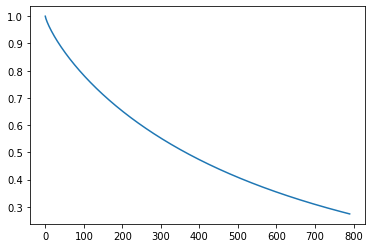

In [49]:
wb = perform_weibull_analysis(synthetic_data)

In the context of a Weibull survival analysis, the shape parameter k or ρ is a crucial component that influences the hazard function, and determines the shape.

In our case k = 0.81 or k<1 or ρ<1 implies a decreasing hazard rate, which in this context can be translated as the patching process experiencing a decreasing "risk of failure" or remediation over time.

In [50]:
# Predicting likelihood of survival
wb.predict(180)

0.6746741554383866

In [51]:
# Perform Weibull AFT analysis and plot partial effects.

def perform_weibull_aft_analysis(data):
    # Check if 'CVE_ID' column exists in the DataFrame
    if 'CVE_ID' in data.columns:
        data = data.drop(columns=['CVE_ID'])
    if 'Observed_Date' in data.columns:
        data = data.drop(columns=['Observed_Date'])
    # Encode categorical variables to numerical values
    label_encoder = LabelEncoder()
    data['Criticality'] = label_encoder.fit_transform(data['Criticality'])

    # Add a small positive value to zero elements in 'Time_to_Remediate'
    data['Time_to_Remediate'] = np.maximum(data['Time_to_Remediate'], 1e-6)

    aft = WeibullAFTFitter()

    # Fit the Weibull AFT model
    aft.fit(data, duration_col='Time_to_Remediate', event_col='Remediated', show_progress=True)

    # Print the summary
    aft.print_summary()

    # Plot the partial effects for 'Criticality'
    aft.plot_partial_effects_on_outcome(covariates='Criticality', values=np.unique(data['Criticality']), cmap='coolwarm')
    plt.title("Effect of Criticality on Survival Time")
    plt.show()

    # Plot the partial effects for 'Exploitability'
    aft.plot_partial_effects_on_outcome(covariates='Exploitability', values=np.unique(data['Exploitability']), cmap='coolwarm')
    plt.title("Effect of Exploitability on Survival Time")
    # Hide the legend
    plt.legend().set_visible(False)
    plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.5824937631193543
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19
     fun: 3.5824937631193543
     jac: array([-6.87710416e-06,  2.26222224e-06, -2.09358519e-06, -1.54526745e-06,
       -1.66539417e-06,  1.45570625e-06])
 message: 'Optimization terminated successfully'
    nfev: 20
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([-1.37227104e-02,  1.05274199e-02,  5.49384197e-04,  1.36762814e-02,
        6.36756855e+00, -2.16514360e-01])


<lifelines.WeibullAFTFitter: fitted with 10000 total observations, 5020 right-censored observations>
             duration col = 'Time_to_Remediate'
                event col = 'Remediated'
   number of observations = 10000
number of events observed = 4980
           log-likelihood = -35824.94
         time fit was run = 2023-12-15 21:28:30 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                              
lambda_ CVSS_Score      -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
        Criticality      0.01       1.01       0.03            -0.04             0.07                 0.96                 1.07
        Exploitability   0.00       1.00       0.17            -0.32             0.33                 0.72                 1.39
        Known_Exploit    0.06       1.06       0.09            -0.11             0.23                 0.90                 1.25
        Intercept        6.37     582.64       0.09             6.18             6.55               485.05               699.86
rho_    Intercept       -0.22       0.81       0.01            -0.24            -0.19                 0.78                 0.83

                         cmp to      z      p   -log2(p)
param   covariate                                       
lambda_ CVSS_Score         0.00  -0.60   0.55       0.87
        Criticality        0.00   0.47   0.64       0.65
        Exploitability     0.00   0.03   0.98       0.03
        Known_Exploit      0.00   0.69   0.49       1.03
        Intercept          0.00  68.08 <0.005        inf
rho_    Intercept          0.00 -16.45 <0.005     199.59
---
Concordance = 0.50
AIC = 71661.88
log-likelihood ratio test = 2.28 on 4 df
-log2(p) of ll-ratio test = 0.55

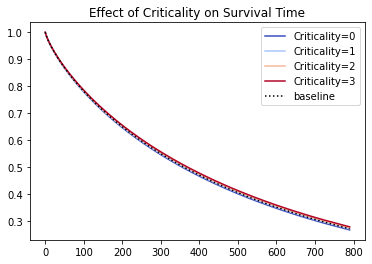

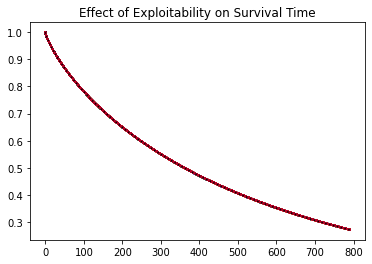

In [52]:
# Perform Weibull AFT analysis
perform_weibull_aft_analysis(synthetic_data)

Let's interpret the key components:

**Coefficient Summary:**
- **Lambda_ and Rho_:** Refer to the scale and shape parameters in the Weibull model, respectively.
- **Coef:** The estimated coefficient for each variable in the model.
- **Exp(Coef):** The exponential of the estimated coefficient, which is the hazard ratio.
- **SE(Coef):** The standard error of the estimated coefficient.
- **Coef Lower/Upper 95%:** The 95% confidence intervals for the coefficients.
- **Exp(Coef) Lower/Upper 95%:** The 95% confidence intervals for the hazard ratios.
- **Z:** The z-score for testing the null hypothesis that the coefficient is zero (no effect).
- **P:** The p-value for the hypothesis test associated with the z-score.
- **-Log2(P):** The negative binary logarithm of the p-value, which is a measure of the significance level in bits.

Let's interpret each of the cofficient's values:
1. **CVSS_Score:**
- Coefficient (coef): -0.01. A negative coefficient implies that higher CVSS scores are associated with a decrease in the expected time to remediation.
- Exponentiated Coefficient (exp(coef)): 0.99. This is the hazard ratio; since it's less than 1, it indicates that as the CVSS score increases, the hazard decreases slightly (vulnerabilities are remediated marginally slower).
- Standard Error (se(coef)): 0.01. This is the standard error of the coefficient estimate.
- 95% Confidence Interval (CI): From -0.02 to 0.01 for the coefficient, and from 0.98 to 1.01 for the hazard ratio. Since this CI includes 0 for the coefficient and 1 for the hazard ratio, it suggests that this variable is not a statistically significant predictor of remediation time.
- Z-score (z): -0.60. This is the test statistic for the hypothesis that the coefficient equals 0.
- P-value (p): 0.55. A p-value higher than 0.05 suggests that the effect is not statistically significant.
- Negative Log2(p): 0.87. This is another measure of statistical significance.
2. **Criticality:**
- Coef: 0.01. This suggests a very slight increase in the hazard with higher criticality, potentially meaning that higher criticality vulnerabilities are remediated marginally faster.
The CI and p-value indicate that this is not statistically significant.
3. **Exploitability:**
- Coef: 0.00. There is no clear association between exploitability and the time to remediation based on this coefficient. The wide CI and p-value near 1 suggest non-significance.
4. **Known_Exploit:**
- Coef: 0.06. This suggests that vulnerabilities with known exploits are associated with a slight increase in the hazard of being remediated. However, the CI includes 0 and the p-value indicates non-significance.



**Intercept (lambda_):**
- Coef: 6.37. This is a significant positive value that affects the baseline hazard function for the lambda parameter.
The exponentiated intercept indicates a large baseline hazard.
The CI does not include 0, and the p-value is very small, indicating statistical significance.**Concordance:** 

The concordance index is 0.50, which means that the model is performing no better than random chance in predicting the event times. A concordance of 0.50 is essentially the same as a coin toss, indicating that the model has no predictive power.


**AIC (Akaike Information Criterion):** 

The AIC is a measure of the relative quality of statistical models for a given set of data. With a value of 71661.88, without other models to compare to, it's hard to judge whether this is high or low. However, in general, when comparing models, the one with the lower AIC is preferred. The AIC penalizes complexity, so a model that fits the data well with fewer parameters will have a lower AIC.


**Log-likelihood Ratio Test:** 

This test compares the fit of your model against a null model with fewer predictors. The result of the test is 2.28 on 4 degrees of freedom (df).

**-log2(p) of ll-ratio test:** 

A value of 0.55 is very low, which suggests that the model is not significantly better than the null model. In other words, the predictors you've included don't significantly improve the model compared to a model without them. This is consistent with the p-values and confidence intervals you provided earlier, which suggested that the individual coefficients were not statistically significant.

***

In summary, the additional metrics support the conclusion that your model is not effectively predicting the time to remediation based on the variables included. The concordance index, in particular, suggests that the model's predictions are no better than random guessing. 

***
### Recreate synthetic dataset
***

Since our synthetically generated data set is not indicative of a real scenario let's introduce some more assumptions in the data generation:
- assume time to remediate is somehow reflective of the criticality of the vulnerabilities
- instead of a random chance of all vulnerabilities to be remedied, assume some are more likely than others

In [53]:
# Generate a synthetic dataset with time-to-remediate based on the criticality score.
def generate_synthetic_data(original_data, num_samples, criticality_ratio):

    # Define mean and standard deviation for each criticality level
    time_to_remediate_stats = {
        'Critical': (5, 1),
        'High': (30, 10),
        'Medium': (90, 30),
        'Low': (300, 100),
    }
    
    # Define probabilities for 'Remediated' status based on criticality level
    remediation_probability = {
        'Critical': [0.3, 0.7],  # 30% not remediated, 70% remediated
        'High': [0.5, 0.5],      # 50% chance
        'Medium': [0.7, 0.3],    # 70% not remediated, 30% remediated
        'Low': [0.5, 0.5],       # Random chance
    }

    # Check if the 'Criticality' and 'Exploitability' columns are present in the original data
#     required_columns = {'Criticality', 'epss', 'cvssScore', 'publishedDate'}
#     if not required_columns.issubset(original_data.columns):
#         raise KeyError(f"The columns {required_columns} are not present in the original_data DataFrame.")

    # Check if the criticality_ratio is valid
    if len(criticality_ratio) != len(original_data['Criticality'].unique()):
        raise ValueError("The length of criticality_ratio should match the number of unique criticality scores.")

    # Get the current date and time in UTC, minus one week
    current_date_minus_one_week = pd.Timestamp.now(tz='UTC') - timedelta(weeks=1)
    
    # Initialize an empty DataFrame for the synthetic data
    synthetic_data = pd.DataFrame(columns=['Time_to_Remediate', 'Criticality', 'CVSS_Score', 'Exploitability',  'Known_Exploit', 'CVE_ID', 'Remediated', 'Observed_Date'])

    # Generate synthetic data based on the given ratio
    for ratio, crit_level in zip(criticality_ratio, original_data['Criticality'].unique()):
        # Check if there are vulnerabilities for the current criticality level
        if crit_level not in original_data['Criticality'].values:
            continue

        # Calculate the number of samples for the current criticality level
        num_samples_crit_level = int(num_samples * ratio)

        # Randomly select vulnerabilities for the current criticality level
        subset_data = original_data[original_data['Criticality'] == crit_level]

        # Check if there are vulnerabilities for the current criticality level
        if subset_data.empty:
            continue

        sampled_indices = np.random.choice(subset_data.index, size=num_samples_crit_level, replace=True)

        # Extract CVSS scores for selected vulnerabilities
        cvss_score = subset_data.loc[sampled_indices, 'cvssScore'].values

        # Extract exploitability scores for selected vulnerabilities
        exploitability = subset_data.loc[sampled_indices, 'epss'].values
        
        # Get mean and standard deviation for the criticality level
        mean_days, std_dev_days = time_to_remediate_stats[crit_level]

        known_exploit = subset_data.loc[sampled_indices, 'hasKEV'].values
        cve_id = subset_data.loc[sampled_indices, 'cveID'].values

       # Generate random Observed_Dates
        published_dates = subset_data.loc[sampled_indices, 'publishedDate']
        observed_dates = published_dates.apply(
            lambda x: x + (current_date_minus_one_week - x) * np.random.rand()
        )
        # Generate normally distributed 'Time_to_Remediate' data around the mean days for the criticality level
        days_to_remediate = np.random.normal(mean_days, std_dev_days, num_samples_crit_level)
        days_to_remediate = np.clip(days_to_remediate, 1, None)  # Ensure all times are positive

        # Calculate 'Observed_Date' by adding the 'days_to_remediate' to the 'publishedDate'
        published_dates = subset_data.loc[sampled_indices, 'publishedDate']
        observed_dates = published_dates + pd.to_timedelta(days_to_remediate, unit='D')

        # Generate 'Remediated' status based on criticality level
        probabilities = remediation_probability[crit_level]
        remediated_status = np.random.choice([0, 1], size=num_samples_crit_level, p=probabilities)

       # Create a DataFrame with the generated data
        synthetic_subset = pd.DataFrame({
            'Time_to_Remediate': days_to_remediate,
            'Criticality': [crit_level] * num_samples_crit_level,
            'CVSS_Score': cvss_score,
            'Exploitability': exploitability,
            'Remediated': remediated_status,  
            'Known_Exploit': known_exploit,
            'CVE_ID': cve_id,
            'Observed_Date': observed_dates
 
        })

        # Append the synthetic subset to the overall synthetic data
        synthetic_data = synthetic_data.append(synthetic_subset)

    # Reset the index of the synthetic data
    synthetic_data.reset_index(drop=True, inplace=True)

    return synthetic_data


In [54]:
# Generate synthetic data with NUM_SAMPLES vulnerabilities
synthetic_data = generate_synthetic_data(original_data, NUM_SAMPLES, CRITICALITY_RATIO)

In [55]:
# Convert relevant columns to numeric and handle NaNs
synthetic_data['Time_to_Remediate'] = pd.to_numeric(synthetic_data['Time_to_Remediate'], errors='coerce')
synthetic_data['Remediated'] = pd.to_numeric(synthetic_data['Remediated'], errors='coerce')

In [56]:
synthetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   Time_to_Remediate  10000 non-null  float64            
 1   Criticality        10000 non-null  object             
 2   CVSS_Score         10000 non-null  float64            
 3   Exploitability     10000 non-null  float64            
 4   Known_Exploit      10000 non-null  float64            
 5   CVE_ID             10000 non-null  object             
 6   Remediated         10000 non-null  int64              
 7   Observed_Date      10000 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(2)
memory usage: 625.1+ KB


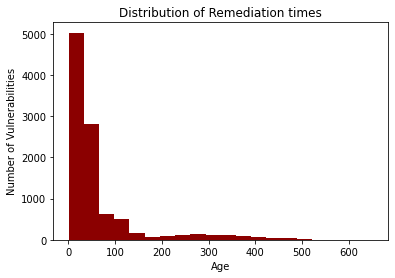

In [57]:
# Plot the distribution of exploitability values
plot_age_distribution(synthetic_data)

In [58]:
# Assuming 'Remediated' is a binary column where 1 indicates remediation
remediation_rate = synthetic_data['Remediated'].mean()

# Convert rate to a percentage
print(f"Remediation rate: {remediation_rate * 100:.2f}%")

Remediation rate: 47.36%


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 10000 total observations, 5264 right-censored observations>
   number of observations = 10000
number of events observed = 4736
           log-likelihood = -27948.52
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 138.67       2.25           134.25           143.08
rho_      0.91       0.01             0.89             0.93

          cmp to     z      p   -log2(p)
lambda_     1.00 61.16 <0.005        inf
rho_        1.00 -9.37 <0.005      66.93
---
AIC = 55901.04

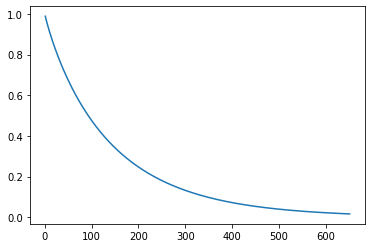

In [59]:
wb = perform_weibull_analysis(synthetic_data)

In [60]:
# Predicting likelihood of survival
wb.predict(180)

0.281241081856161

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.3168257320079504
            Iterations: 16
            Function evaluations: 24
            Gradient evaluations: 16
     fun: 2.3168257320079504
     jac: array([-1.72783934e-06,  2.70876988e-06,  5.54020993e-06,  2.31177199e-06,
        1.63782284e-06,  3.12004166e-07])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([-5.48638664e-01,  4.48366272e-01, -4.64670018e-04, -4.30871746e-03,
        4.89281230e+00,  9.45503403e-01])


<lifelines.WeibullAFTFitter: fitted with 10000 total observations, 5264 right-censored observations>
             duration col = 'Time_to_Remediate'
                event col = 'Remediated'
   number of observations = 10000
number of events observed = 4736
           log-likelihood = -23168.26
         time fit was run = 2023-12-15 21:28:36 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                              
lambda_ CVSS_Score      -0.22       0.80       0.00            -0.22            -0.21                 0.80                 0.81
        Criticality      0.57       1.76       0.02             0.54             0.60                 1.71                 1.81
        Exploitability  -0.00       1.00       0.05            -0.10             0.10                 0.90                 1.10
        Known_Exploit   -0.02       0.98       0.02            -0.07             0.03                 0.94                 1.03
        Intercept        4.89     133.33       0.04             4.82             4.97               124.02               143.34
rho_    Intercept        0.95       2.57       0.01             0.92             0.97                 2.52                 2.63

                         cmp to      z      p   -log2(p)
param   covariate                                       
lambda_ CVSS_Score         0.00 -72.38 <0.005        inf
        Criticality        0.00  37.71 <0.005    1031.38
        Exploitability     0.00  -0.08   0.94       0.09
        Known_Exploit      0.00  -0.74   0.46       1.13
        Intercept          0.00 132.46 <0.005        inf
rho_    Intercept          0.00  85.36 <0.005        inf
---
Concordance = 0.74
AIC = 46348.51
log-likelihood ratio test = 9560.53 on 4 df
-log2(p) of ll-ratio test = inf

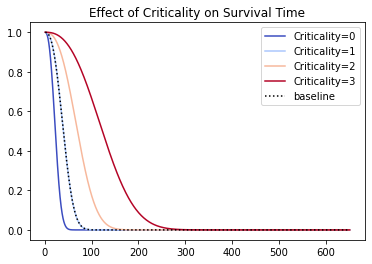

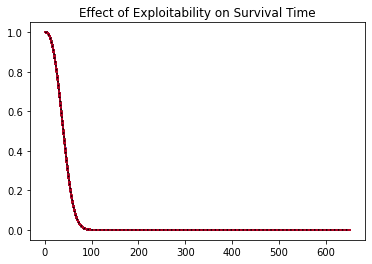

In [61]:
# Perform Weibull AFT analysis
perform_weibull_aft_analysis(synthetic_data)

Let's interpret each part of the results:

**Coefficients (coef):**
- **CVSS_Score:** The coefficient is -0.22, suggesting that higher CVSS scores are associated with a reduction in the expected time until the event occurs (e.g., remediation of a vulnerability). Since exp(coef) is 0.80, for each one-unit increase in CVSS Score, the time to remediate is multiplied by 0.80, indicating a 20% decrease, assuming all other variables are held constant. This is highly statistically significant, as shown by the p-value and the Z-score.
- **Criticality:** With a coefficient of 0.56 and exp(coef) of 1.74, this implies that as the criticality level increases by one unit, the expected time to remediation is 1.74 times longer, or there's a 74% increase in the time to remediation. This effect is statistically significant.
- **Exploitability:** The coefficient of -0.09 and exp(coef) of 0.92 indicate a slight reduction in the time to remediation as exploitability increases, but this is not statistically significant, as indicated by the p-value of 0.07.
- **Known_Exploit:** The coefficient of 0.02 and exp(coef) of 1.02 suggest a slight increase in the time to remediation when a known exploit is present, but this is not statistically significant (p = 0.34).

**Intercept:**

The intercept for lambda_ is significant with a coefficient of 4.91, and for rho_ it is 0.96. Both are statistically significant and have a large impact on the model. The lambda_ intercept affects the scale of the survival curve, while the rho_ intercept affects its shape. The positive rho_ intercept indicates the hazard rate increases over time.

**Concordance:**

A concordance index of 0.74 indicates good predictive ability of the model. A value of 1.0 would be perfect prediction, 0.5 is no better than random chance, and 0.74 is substantially better than a coin flip.

**Akaike Information Criterion (AIC):**
An AIC of 47058.81 provides a measure of the relative quality of the model. It considers the complexity of the model (number of predictors) and the goodness of fit.

**Log-likelihood Ratio Test:**
The test statistic of 9974.10 on 4 degrees of freedom is extremely high, indicating that the model provides a significantly better fit to the data than the null model (a model with no predictors). The -log2(p) value is infinite, which underscores the strong significance of the model.


***
The results suggest that CVSS_Score and Criticality are significant predictors of the time to remediation in your model, with CVSS_Score decreasing the expected time and Criticality increasing it. The model has good predictive power as indicated by the concordance index, and it significantly improves upon the null model.

This is of course normal in this example, and reflects the assumptions behind the synthetically generated data.

***
### Survival by Criticality Level
***

In [62]:
# Function to perform survival analysis and plot survival and hazard functions
def perform_survival_analysis(data, criticality_level):
    kmf = KaplanMeierFitter()

    # Filter data for the specified criticality level
    subset_data = data[data['Criticality'] == criticality_level]

    # Identify events (1) and censored observations (0)
    event_observed = np.where(subset_data['Remediated'] == 1, 1, 0)

    # Fit the Kaplan-Meier estimator
    kmf.fit(durations=subset_data['Time_to_Remediate'], event_observed=event_observed)

    # Check if there is variation in survival probabilities
    if len(np.unique(kmf.survival_function_.values)) > 1:
        # Plot the survival curve
        kmf.plot_survival_function()

         # Add censoring indicators
        censored = subset_data.loc[subset_data['Remediated'] == 0]
        plt.scatter(censored['Time_to_Remediate'], kmf.survival_function_.loc[censored['Time_to_Remediate']].values, 
                    alpha=0.5, c='red', marker='+')
       # Add labels and title
        plt.title(f"Survival Analysis for {criticality_level} Criticality")
        plt.xlabel("Time to Remediate (days)")
        plt.ylabel("Survival Probability")

        # Display the survival plot
        plt.show()

        kmf.plot_cumulative_density()
        # Add labels and title
        plt.title(f"Cumulative Survival Curve for {criticality_level} Criticality")
        plt.xlabel("Time to Remediate (days)")
        plt.ylabel("Hazard Function (proportional)")
        

        # Display the hazard plot
        plt.show()
    else:
        print(f"No variation in survival probabilities for {criticality_level} Criticality. Hazard plot not generated.")
    return kmf

In the context of survival analysis, especially when analyzing time-to-event data like time-to-remediation of vulnerabilities, the term "half-life" has a specific interpretation. It refers to the median survival time, which is the time at which half of the studied subjects (in this case, vulnerabilities) have experienced the event of interest (here, remediation).

Here's what half-life signifies in our context and how we can use it:

- **Median Time to Remediation**: The half-life is the point in time by which 50% of the vulnerabilities have been remediated. It represents a median experience in your dataset — half of the vulnerabilities are remediated faster than this time, and half take longer.
- **Indicator of Response Speed**: A shorter half-life indicates that vulnerabilities are being addressed relatively quickly. Conversely, a longer half-life suggests slower remediation processes.
- **Benchmark for Comparison**: It can be used as a benchmark to compare different groups or categories within your data. For example, you might find that 'Critical' vulnerabilities have a shorter half-life compared to 'Low' vulnerabilities, indicating quicker remediation.

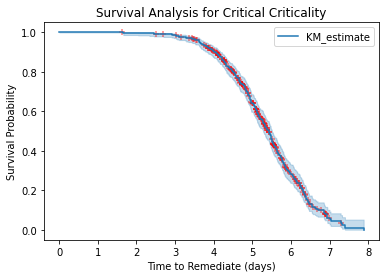

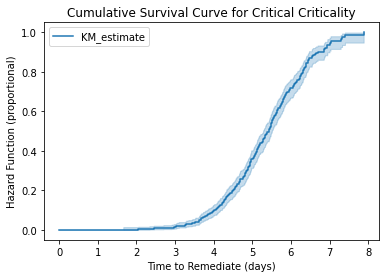

In [63]:
kmf = perform_survival_analysis(synthetic_data, 'Critical')

In survival analysis, the median survival time is the time at which the survival probability drops to 0.5 (or 50%). It is the point in time by which half of the observed cases have experienced the event of interest (in this context, it could be the remediation of a vulnerability). The output will give you the estimated time (in the same units as your input data, days) at which you can expect half of the "Critical/High/Medium/Low" vulnerabilities to be remediated.

In [64]:
median_ = kmf.median_survival_time_
print("The median survival duration of Critical vulnerabilities:\n", median_)

Half life of Critical vulnerabilities:
 5.424122925390388


In [65]:
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("The median survival duration of Critical vulnerabilities:\n", median_confidence_interval_)
kmf.survival_function_.tail()

The median survival duration of Critical vulnerabilities:
      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                5.278997                 5.50548


,KM_estimate
timeline,
7.288341,0.035713
7.308533,0.035713
7.324870,0.023809
7.400190,0.011904
7.884721,0.000000


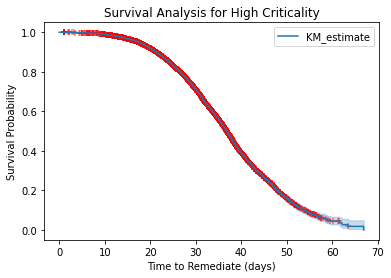

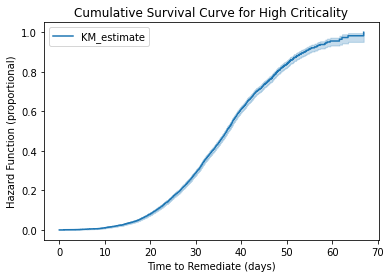

In [66]:
kmf = perform_survival_analysis(synthetic_data, 'High')

In [67]:
median_ = kmf.median_survival_time_
print("The median survival durationof High vulnerabilities:\n", median_)

Half life of High vulnerabilities:
 36.8010068334293


In [68]:
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("The median survival duration of High vulnerabilities:\n", median_confidence_interval_)
kmf.survival_function_.tail()

The median survival duration of High vulnerabilities:
      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5               36.404856               37.233996


,KM_estimate
timeline,
61.589418,0.035508
62.153742,0.026631
63.482072,0.017754
63.545734,0.017754
66.916245,0.000000


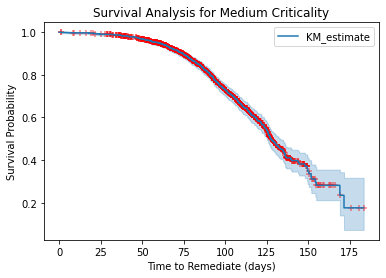

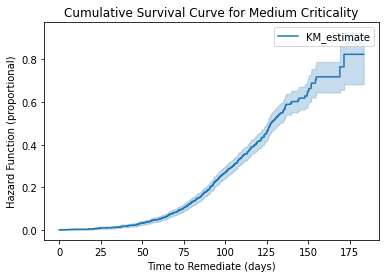

In [69]:
kmf = perform_survival_analysis(synthetic_data, 'Medium')

In [70]:
median_ = kmf.median_survival_time_
print("The median survival duration of Medium vulnerabilities:\n", median_)

Half life of Medium vulnerabilities:
 127.61574958543234


In [71]:
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("The median survival duration of Medium vulnerabilities:\n", median_confidence_interval_)
kmf.survival_function_.tail()

The median survival duration of Medium vulnerabilities:
      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5              125.302066              133.356052


,KM_estimate
timeline,
169.179638,0.234791
171.597364,0.176093
175.640493,0.176093
180.339618,0.176093
183.442470,0.176093


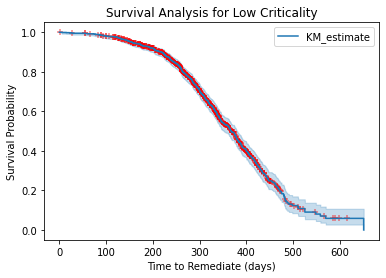

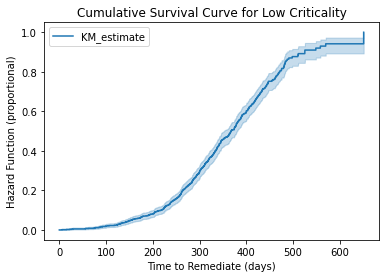

In [72]:
kmf = perform_survival_analysis(synthetic_data, 'Low')

In [73]:
median_ = kmf.median_survival_time_
print("The median survival duration of Low vulnerabilities:\n", median_)

Half life of Low vulnerabilities:
 367.30681090928704


In [74]:
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("The median survival duration of Low vulnerabilities:\n", median_confidence_interval_)
kmf.survival_function_.tail()

The median survival duration of Low vulnerabilities:
      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5              351.908653              380.076066


,KM_estimate
timeline,
586.067526,0.058451
589.043270,0.058451
598.833351,0.058451
616.070211,0.058451
651.219590,0.000000


***
### CoxPH Fitter
***

The proportional hazards assumption: all individuals' hazards are proportional to one another.

In [76]:
# Function to perform Cox Proportional Hazard analysis and plot coefficients
def perform_cox_proportional_hazard(data):
    # Check if 'CVE_ID' column exists in the DataFrame
    if 'CVE_ID' in data.columns:
        data = data.drop(columns=['CVE_ID'])
    if 'Observed_Date' in data.columns:
        data = data.drop(columns=['Observed_Date'])
    # Encode categorical variables to numerical values
    label_encoder = LabelEncoder()
    data['Criticality'] = label_encoder.fit_transform(data['Criticality'])

    cph = CoxPHFitter()

    # Fit the Cox Proportional Hazard model
    cph.fit(data, duration_col='Time_to_Remediate', event_col='Remediated', show_progress=True)

    # Print the summary
    cph.print_summary()

    # Plot the coefficients
    cph.plot_covariate_groups('Criticality', values=np.unique(data['Criticality']), cmap='coolwarm')

    # Display the plot
    plt.show()

    # Plot the coefficients
    cph.plot_covariate_groups('Exploitability', values=np.unique(data['Exploitability']), cmap='coolwarm')
    # Hide the legend
    plt.legend().set_visible(False)
    # Display the plot
    plt.show()
    return cph

Iteration 1: norm_delta = 8.40e-01, step_size = 0.9500, log_lik = -39231.42187, newton_decrement = 2.17e+03, seconds_since_start = 0.2
Iteration 2: norm_delta = 5.92e-01, step_size = 0.9500, log_lik = -36740.27076, newton_decrement = 4.80e+02, seconds_since_start = 0.4
Iteration 3: norm_delta = 4.70e-01, step_size = 0.9500, log_lik = -36163.02787, newton_decrement = 1.34e+02, seconds_since_start = 0.6
Iteration 4: norm_delta = 2.10e-01, step_size = 1.0000, log_lik = -36007.00963, newton_decrement = 1.38e+01, seconds_since_start = 0.8
Iteration 5: norm_delta = 2.59e-02, step_size = 1.0000, log_lik = -35992.26922, newton_decrement = 1.62e-01, seconds_since_start = 0.9
Iteration 6: norm_delta = 2.86e-04, step_size = 1.0000, log_lik = -35992.10609, newton_decrement = 1.93e-05, seconds_since_start = 1.1
Iteration 7: norm_delta = 3.36e-08, step_size = 1.0000, log_lik = -35992.10607, newton_decrement = 2.65e-13, seconds_since_start = 1.3
Convergence success after 7 iterations.


<lifelines.CoxPHFitter: fitted with 10000 total observations, 5264 right-censored observations>
             duration col = 'Time_to_Remediate'
                event col = 'Remediated'
      baseline estimation = breslow
   number of observations = 10000
number of events observed = 4736
   partial log-likelihood = -35992.11
         time fit was run = 2023-12-15 21:28:42 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Criticality     -1.92       0.15       0.06            -2.03            -1.81                 0.13                 0.16
CVSS_Score       0.55       1.73       0.01             0.52             0.57                 1.68                 1.77
Exploitability   0.02       1.02       0.13            -0.24             0.27                 0.79                 1.31
Known_Exploit    0.05       1.05       0.06            -0.08             0.17                 0.93                 1.18

                 cmp to      z      p   -log2(p)
covariate                                       
Criticality        0.00 -32.88 <0.005     785.23
CVSS_Score         0.00  40.39 <0.005        inf
Exploitability     0.00   0.13   0.90       0.15
Known_Exploit      0.00   0.74   0.46       1.12
---
Concordance = 0.74
Partial AIC = 71992.21
log-likelihood ratio test = 6478.63 on 4 df
-log2(p) of ll-ratio test = inf

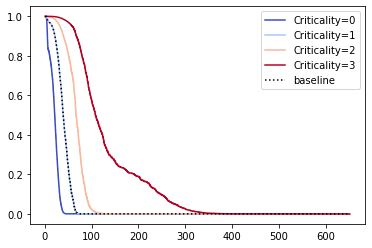

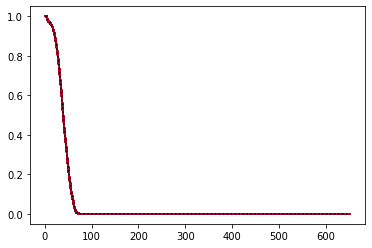

In [77]:
# Perform Cox Proportional Hazard analysis
cph = perform_cox_proportional_hazard(synthetic_data)

In [78]:
# Print model summary
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Criticality,-1.919561,0.146671,0.058380,-2.033984,-1.805138,0.130813,0.164452,0.0,-32.880360,4.195599e-237,785.228082
CVSS_Score,0.545841,1.726060,0.013513,0.519357,0.572326,1.680946,1.772385,0.0,40.393961,0.000000e+00,inf
Exploitability,0.016416,1.016552,0.130737,-0.239824,0.272656,0.786767,1.313448,0.0,0.125567,9.000750e-01,0.151883
Known_Exploit,0.046206,1.047290,0.062763,-0.076807,0.169219,0.926069,1.184380,0.0,0.736204,4.616064e-01,1.115265


<Axes: xlabel='log(HR) (95% CI)'>

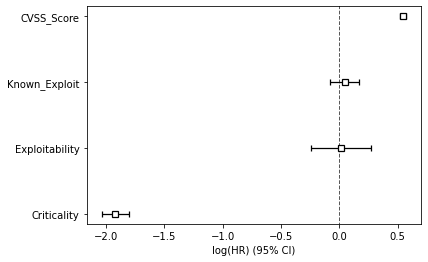

In [79]:
cph.plot()

In the context of survival analysis, particularly when using a Cox proportional hazards model, a forest plot displays the hazard ratios (HRs) for different variables along with their confidence intervals (CIs). Here's how you would interpret the results:

- **Exploitability**:
The point estimate is around -0.25 on the log(HR) scale, which indicates a moderate decrease in the hazard as exploitability increases. The confidence interval for exploitability is narrow and does not cross 0, suggesting that the effect is statistically significant.
- **CVSS Score**:
The point estimate is far to the left, indicating a negative log(Hazard Ratio), which suggests that higher CVSS scores are associated with a decreased hazard (or reduced risk of the event occurring within the study period). The confidence interval does not cross the vertical line at 0, which implies that this variable is statistically significant.

Interpreting the Hazard Ratios (HR):

- A hazard ratio less than 1 suggests that as the predictor variable increases, the event hazard decreases (the event being less likely to happen at any point in time).
- A hazard ratio greater than 1 suggests that as the predictor variable increases, the event hazard increases (the event being more likely to happen at any point in time).
- A hazard ratio close to 1 suggests there is no effect.

It's important to consider the confidence intervals when interpreting these results. If the confidence interval for a hazard ratio crosses 1 (or 0 when log-transformed), it suggests that the effect is not statistically significant at the 95% confidence level, meaning we cannot be confident that there is a true effect in the population from which the sample was drawn.

The `log(HR)` scale is used for better visualization, especially when hazard ratios are close to 1. The '0' point on the x-axis represents a hazard ratio of 1, which indicates no effect.

Since this is synthetically generated data this is not necessarily signficant in any way, but this how the results would be interpreted in a realistic scenario.